In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime, timedelta, date
from statistics import mean, median, mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Stocks Data

In [37]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['^DJI', '^GSPC']
diffCols = ['Close']

# Adds a column to df for the day by day change of col
def add_day_change(df, cols):
    for col in cols:
        try:
            df[col + '_Diff'] = pd.to_numeric(df[col]).pct_change()
            df[col + "_Diff_Increase"] = df[col + '_Diff'] > 0
        except:
            print(f"Unable to calculate diff for {col}")
            
def add_moving_avg(df, col, n):
    try:
        df[f"Moving_Avg_{col}_{n}"] = df[col].rolling(window=n).mean().shift(1)
    except:
        print(f"Unable to calculate moving avg for {col}")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv("../Additional Data/" + symbol + '.csv')
    add_moving_avg(market_dfs[symbol], "Close", 5)
    add_day_change(market_dfs[symbol], diffCols)
    market_dfs[symbol].dropna(inplace=True)

In [38]:
market_dfs['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Avg_Close_5,Close_Diff,Close_Diff_Increase
5,2015-01-09,112.669998,113.250000,110.209999,112.010002,102.916725,53699500,108.296001,0.001073,True
6,2015-01-12,112.599998,112.629997,108.800003,109.250000,100.380791,49650800,108.832001,-0.024641,False
7,2015-01-13,111.430000,112.800003,108.910004,110.220001,101.272049,67091900,109.432001,0.008879,True
8,2015-01-14,109.040001,110.489998,108.500000,109.800003,100.886154,48956600,110.224000,-0.003811,False
9,2015-01-15,110.000000,110.059998,106.660004,106.820000,98.148056,60014000,110.634001,-0.027140,False


## Baselines - Classifiers

In [14]:
def average(results):
    return sum(results) / len(results)

def weighted_average(results, weights):
    return results.dot(abs(weights)) / sum(abs(weights))

### Predicting most common value

In [39]:
for symbol in stocks:
    print(f'{symbol} Accuracy: {average(market_dfs[symbol]["Close_Diff_Increase"])}')
    print(f'{symbol} Weighted Accuracy: {weighted_average(market_dfs[symbol]["Close_Diff_Increase"], market_dfs[symbol]["Close_Diff"])}')

AAPL Average: 0.5255775577557755
AAPL Weighted Average: 0.535286146782845
FB Average: 0.5297029702970297
FB Weighted Average: 0.5375162108571157
NFLX Average: 0.5041254125412541
NFLX Weighted Average: 0.5510448204278133
AMZN Average: 0.5503300330033003
AMZN Weighted Average: 0.5659909326436722
GOOG Average: 0.5305280528052805
GOOG Weighted Average: 0.5424025978837085


### Predicting the previous day's price as the current day's price (last value prediction)

In [43]:
for symbol in stocks: 
    df = market_dfs[symbol]
    predictions = df["Close_Diff_Increase"][:-1]
    actual = df["Close_Diff_Increase"][1:]
    weights = df["Close_Diff"][1:]
    print(f'{symbol} Accuracy: {average(predictions.values == actual.values)}')
    print(f'{symbol} Weighted Accuracy: {weighted_average(predictions.values == actual.values, weights)}')

AAPL Accuracy: 0.4962840627580512
AAPL Weighted Accuracy: 0.5152766274191736
FB Accuracy: 0.47233691164327
FB Weighted Accuracy: 0.48138137286147203
NFLX Accuracy: 0.4731626754748142
NFLX Weighted Accuracy: 0.48142855524316974
AMZN Accuracy: 0.5177539223781998
AMZN Weighted Accuracy: 0.5363167333383195
GOOG Accuracy: 0.5127993393889347
GOOG Weighted Accuracy: 0.5110866462185603


### Using a moving average of prices for the past n days to predict the current day's price

In [58]:
def moving_avg_pred(df, n):
    predictions = df['Close_Diff_Increase'].rolling(window=n).apply(mode, raw=False).shift(1)[n:]
    actual = df['Close_Diff_Increase'][n:]
    print('Last {} days average: {}'.format(n, average(predictions.values == actual.values)))
    print('Last {} days weighted average: {}'.format(n, weighted_average(predictions.values == actual.values, 
                                                                         df['Close_Diff'][n:])))

In [59]:
for symbol in stocks:
    print(symbol)
    for n in range(3, 10, 2):
        moving_avg_pred(market_dfs[symbol], n)

AAPL
Last 3 days average: 0.4946236559139785
Last 3 days weighted average: 0.4966849005920765
Last 5 days average: 0.49461474730737365
Last 5 days weighted average: 0.4967609191975845
Last 7 days average: 0.5020746887966805
Last 7 days weighted average: 0.5219108330263491
Last 9 days average: 0.4937655860349127
Last 9 days weighted average: 0.5236478119094994
FB
Last 3 days average: 0.4598842018196857
Last 3 days weighted average: 0.4618141029756789
Last 5 days average: 0.46975973487986744
Last 5 days weighted average: 0.4743301124488526
Last 7 days average: 0.47800829875518674
Last 7 days weighted average: 0.46393413712728504
Last 9 days average: 0.48212801330008315
Last 9 days weighted average: 0.4895728269579826
NFLX
Last 3 days average: 0.5028949545078577
Last 3 days weighted average: 0.5296182023775718
Last 5 days average: 0.4888152444076222
Last 5 days weighted average: 0.5277135434172738
Last 7 days average: 0.4896265560165975
Last 7 days weighted average: 0.5141570816080927
Las

In [62]:
def makeDfForTimeReg(df, col, n_prev_days=5):
    new_df = pd.DataFrame(df[col])
    for i in range(n_prev_days):
        new_df[col + "_" + str(i+1)] = new_df[col].shift(i+1)
    return new_df.dropna(axis=0)

In [80]:
n_prev_days = 9
for symbol in stocks:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    df["Close_Diff_Increase"] = market_dfs[symbol]["Close_Diff_Increase"]
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff_Increase", "Close_Diff"]
    X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = KNeighborsClassifier()
    classifier.fit(X_train, y_train["Close_Diff_Increase"])
    
    preds = classifier.predict(X_test)
    
    acc = average(preds == y_test['Close_Diff_Increase'])
    weighted_acc = weighted_average(preds == y_test['Close_Diff_Increase'], y_test['Close_Diff'])
    print(f'Last {n_prev_days} days acc: {acc}')
    print(f'Last {n_prev_days} days weighted acc: {weighted_acc}')

AAPL
Last 9 days acc: 0.5020746887966805
Last 9 days weighted acc: 0.49306804383977215
FB
Last 9 days acc: 0.5892116182572614
Last 9 days weighted acc: 0.5528589105772114
NFLX
Last 9 days acc: 0.5145228215767634
Last 9 days weighted acc: 0.5124340493926186
AMZN
Last 9 days acc: 0.5684647302904564
Last 9 days weighted acc: 0.5334718513449654
GOOG
Last 9 days acc: 0.47717842323651455
Last 9 days weighted acc: 0.4146101407648929


## Baselines - Regression

In [195]:
from sklearn.metrics import mean_squared_error

In [197]:
def plot_preds_vs_actual(preds, actual, title):
    # Figsize
    plt.figure(figsize=(10,6))
    
    plt.plot(range(len(preds)), preds)
    plt.plot(range(len(preds)), actual)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Daily % Change")
    plt.gca().legend(["Predictions", "Labels"])

### Predicting the average

In [20]:
mean_predictions = [mean(sp500['Close_Diff'])] * len(sp500['Close_Diff'])
median_predictions = [median(sp500['Close_Diff'])] * len(sp500['Close_Diff'])
actual = sp500['Close_Diff']

print('Mean: {}'.format(mean_squared_error(actual, mean_predictions)))
print('Median: {}'.format(mean_squared_error(actual, median_predictions)))

Mean: 493.901657491231
Median: 494.22631884436794


### Predicting the previous day's price as the current day's price (last value prediction)

In [101]:
for symbol in stocks: 
    print(symbol)
    preds = market_dfs[symbol]['Close_Diff'][:-1]
    actual = market_dfs[symbol]['Close_Diff'][1:]
    print(f"Last value prediction MSE: {mean_squared_error(actual.values, preds.values)}")


AAPL
Last value prediction MSE: 0.000495809577819944
FB
Last value prediction MSE: 0.0006462979788012922
NFLX
Last value prediction MSE: 0.0013598857408902594
AMZN
Last value prediction MSE: 0.0006853207626204932
GOOG
Last value prediction MSE: 0.0004555249281737049


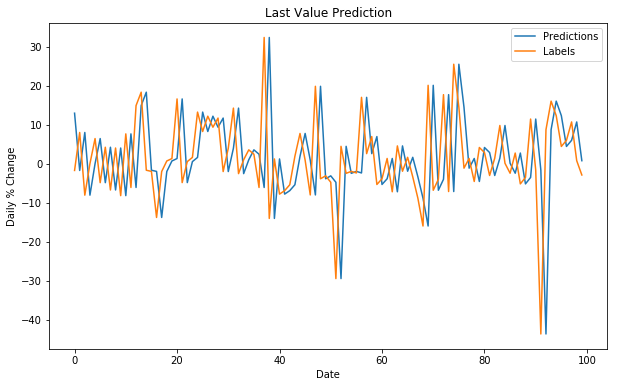

In [97]:
plot_preds_vs_actual(predictions[:100], actual[:100], "Last Value Prediction")

### Using a moving average of prices for the past n days to predict the current day's price

In [110]:
n_prev_days = 4

for symbol in stocks: 
    print(symbol)
    actual = market_dfs[symbol]['Close_Diff'][n_prev_days:]
    preds = market_dfs[symbol]['Close_Diff'].rolling(window=n_prev_days).apply(mean, raw=False).shift(1)[n_prev_days:]
    print(f"Last {n_prev_days} MSE: {mean_squared_error(actual.values, preds.values)}")

AAPL
Last 4 MSE: 0.00031513233267016483
FB
Last 4 MSE: 0.0004151713576879585
NFLX
Last 4 MSE: 0.000863162300370415
AMZN
Last 4 MSE: 0.0004462403425329434
GOOG
Last 4 MSE: 0.0003000447514222474


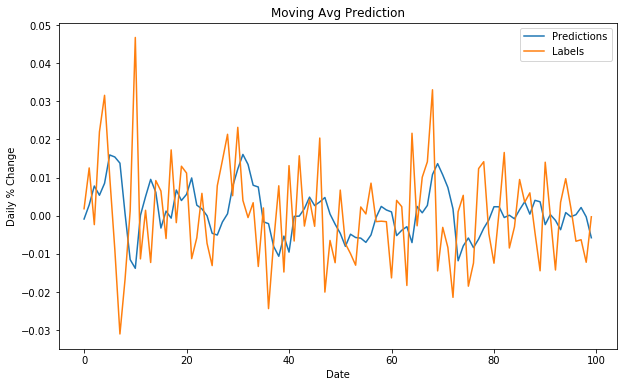

In [111]:
plot_preds_vs_actual(preds[:100], actual[:100], "Moving Avg Prediction")

In [22]:
print('Mean: ')
for n in range(2, 10):
    predictions = sp500['Close_Diff'].rolling(window=n).apply(mean, raw=False).shift()[n:]
    actual = sp500['Close_Diff'][n:]
    print('Last {} days: {}'.format(n, mean_squared_error(actual.values, predictions.values)))
    
print('\nMedian: ')
for n in range(2, 10):
    predictions = sp500['Close_Diff'].rolling(window=n).apply(median, raw=False).shift()[n:]
    actual = sp500['Close_Diff'][n:]
    print('Last {} days: {}'.format(n, mean_squared_error(actual.values, predictions.values)))

Mean: 
Last 2 days: 776.797729173118
Last 3 days: 655.1352998934882
Last 4 days: 621.9076860565056
Last 5 days: 607.6424449137635
Last 6 days: 590.5040267915564
Last 7 days: 566.0162416813055
Last 8 days: 572.2019222251441
Last 9 days: 559.4475981465187

Median: 
Last 2 days: 776.797729173118
Last 3 days: 679.1258591807976
Last 4 days: 634.805955401581
Last 5 days: 632.9022678013438
Last 6 days: 600.6223069411042
Last 7 days: 593.580351209557
Last 8 days: 587.4457761683861
Last 9 days: 565.7323924907972


### Using a time series based linear regression without news data and with the previous n days as features

In [125]:
def tt_split(X, y, test_size=0.2):
    assert len(X) == len(y)
    
    n_test = int(len(X)*test_size)
    
    X_train = X.loc[:len(X)-n_test]
    y_train = y.loc[:len(X)-n_test]
    X_test = X.loc[len(X)-n_test:]
    y_test = y.loc[len(X)-n_test:]
    return X_train, X_test, y_train, y_test

In [160]:
n_prev_days = 10
for symbol in stocks:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')


AAPL
Last 10 days MSE: 0.00038164825646030373
FB
Last 10 days MSE: 0.00041551484854250256
NFLX
Last 10 days MSE: 0.000654141522807294
AMZN
Last 10 days MSE: 0.00043000870183478073
GOOG
Last 10 days MSE: 0.00030914604080495593


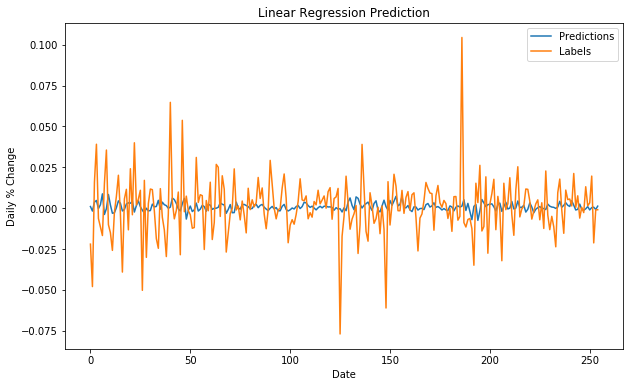

In [161]:
plot_preds_vs_actual(preds, y_test, "Linear Regression Prediction")

In [164]:
n_prev_days = 3
for symbol in stocks:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Lasso(alpha=0.00001)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')

AAPL
Last 3 days MSE: 0.0003722499924765338
FB
Last 3 days MSE: 0.00041026578826348914
NFLX
Last 3 days MSE: 0.000619752002531244
AMZN
Last 3 days MSE: 0.00037845476327699946
GOOG
Last 3 days MSE: 0.00029558380702768093


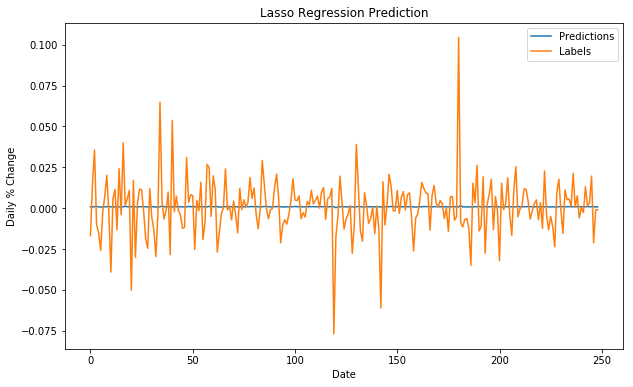

In [165]:
plot_preds_vs_actual(preds, y_test, "Lasso Regression Prediction")

In [175]:
n_prev_days = 8
for symbol in stocks:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close", n_prev_days=n_prev_days)
    
    X_cols = ["Close_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Lasso(alpha=1)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')

AAPL
Last 8 days MSE: 13.616612357875354
FB
Last 8 days MSE: 10.911601034526134
NFLX
Last 8 days MSE: 61.041854478943634
AMZN
Last 8 days MSE: 1093.5291351540468
GOOG
Last 8 days MSE: 388.15628794944274


/Users/adamskrocki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


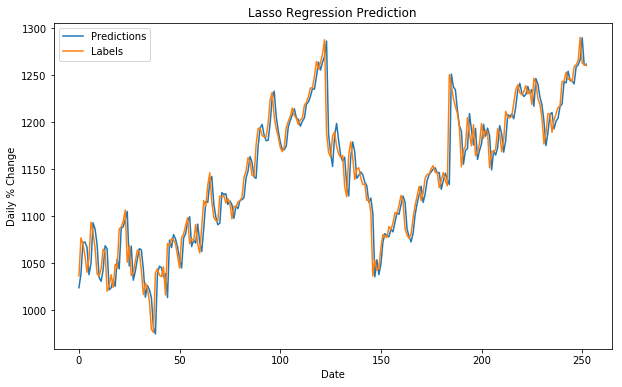

In [176]:
plot_preds_vs_actual(preds, y_test, "Lasso Regression Prediction")

In [184]:
n_prev_days = 8
for symbol in stocks:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close", n_prev_days=n_prev_days)
    
    X_cols = ["Close_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Ridge(alpha=5)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')

AAPL
Last 8 days MSE: 13.45903341801791
FB
Last 8 days MSE: 10.948433389223547
NFLX
Last 8 days MSE: 63.425365375315245
AMZN
Last 8 days MSE: 1127.2220962716208
GOOG
Last 8 days MSE: 387.8600324428382


In [193]:
y_test.values

array([[1036.209961],
       [1076.77002 ],
       [1070.      ],
       [1057.790039],
       [1040.089966],
       [1055.810059],
       [1093.390015],
       [1082.400024],
       [1066.150024],
       [1038.630005],
       [1036.050049],
       [1043.660034],
       [1064.709961],
       [1061.48999 ],
       [1020.      ],
       [1025.76001 ],
       [1037.609985],
       [1023.880005],
       [1048.619995],
       [1044.410034],
       [1086.22998 ],
       [1088.300049],
       [1094.430054],
       [1106.430054],
       [1050.819946],
       [1068.72998 ],
       [1036.579956],
       [1039.550049],
       [1051.75    ],
       [1063.680054],
       [1061.900024],
       [1042.099976],
       [1016.530029],
       [1028.709961],
       [1023.01001 ],
       [1009.409973],
       [ 979.539978],
       [ 976.219971],
       [1039.459961],
       [1043.880005],
       [1037.079956],
       [1035.609985],
       [1045.849976],
       [1016.059998],
       [1070.709961],
       [10

In [194]:
(preds > 0)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [190]:
weighted_average((preds > 0)[:], y_test.values)

ValueError: shapes (253,1) and (253,1) not aligned: 1 (dim 1) != 253 (dim 0)

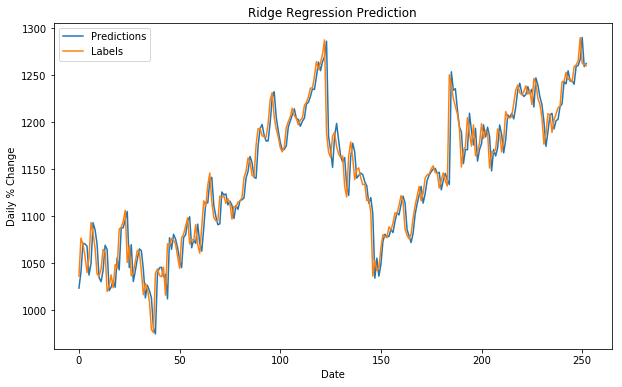

In [185]:
plot_preds_vs_actual(preds, y_test, "Ridge Regression Prediction")

Looks like it learns to basically just predict the previous day (i.e. weight for the previous day is high and rest are low)